# Dataset

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [64]:
from torch.utils.data import Dataset
from dgllife.model.model_zoo.dgmg import MoleculeEnv

class MoleculeDataset(object):
    """Initialize and split the dataset
    
    Parameters
    ----------
    dataset : str
        Dataset name
    order : None (default) or str
        Order to extract a decision sequence for generating a molecule.
    modes : None (default) or list
        List of subsets to use, which can contain 'train', 'val'.
    subset_id : int
        With multiprocess training, we partition the training set into multiple subsets
        and each process will use only one subset only.
        This subset_id corresponds to subprocess id.
    n_subsets : int
        With multiprocess training, this corresponds to the number of total subprocesses.
    """
    def __init__(self, dataset, order=None, modes=None, subset_id=0, n_subsets=1):
        super(MoleculeDataset, self).__init__()
        
        if modes == None:
            modes = []
        else:
            assert order is not None, 'An order should be specified for extracting ' \
                                      'decision sequences.'
        
        assert order in ['random', 'canonical', None], 'Unexpected order option to get sequences of graph generation decisions'
        assert len(set(modes) - {'train', 'val'}) == 0, "modes should be a list, representing a subset of ['train', 'val']"
        
        self.dataset = dataset
        self.order = order
        self.modes = modes
        self.subset_id = subset_id
        self.n_subsets = n_subsets
        self._setup()
        
    def collate(self, samples):
        """PyTorch's approach to batch multiple samples.
        
        For auto-regressive generative models, we process one sample at a time.
        
        Parameters
        ----------
        samples : list
            A list of length 1 that consists of decision sequence to generate a molecule.
        
        Returns
        -------
        list
            List of 2-tuples, a decision sequence to generate a molecule.
        """
        assert len(samples) == 1
        return samples[0]
    
    def _create_a_subset(self, smiles):
        """Create a dataset from a subset of smiles.
        
        Parameters
        ----------
        smiles : list or str
            Lists of molecules in SMILES format
        """
        # divide the smiles into multiple subsets with multiprocess
        subset_size = len(smiles) // self.n_subsets
        return Subset(smiles[self.subset_id * subset_size: (self.subset_id + 1) * subset_size], self.order, self.env)
    
    def _setup(self):
        """
        1. Instantiate an MDP environment for molecule generation
        2. Download the dataset, which is a file of SMILES
        3. Create subsets for training and validation
        """
        if self.dataset == 'ChEMBL':
            # For new datasets, get_atom_and_bond_types can be used to
            # identify the atom and bond types in them.
            self.atom_types = ['O', 'Cl', 'C', 'S', 'F', 'Br', 'N']
            self.bond_types = [Chem.rdchem.BondType.SINGLE,
                               Chem.rdchem.BondType.DOUBLE,
                               Chem.rdchem.BondType.TRIPLE]
            
        elif self.dataset == 'ZINC':
            self.atom_types = ['C', 'N', 'O', 'P', 'S', 'F', 'Cl', 'Br', 'I']
            self.bond_types = [Chem.rdchem.BondType.SINGLE,
                               Chem.rdchem.BondType.DOUBLE,
                               Chem.rdchem.BondType.TRIPLE]
        
        else:
            path_to_atom_and_bond_type = '_'.join([self.dataset, 'atom_and_bond_types.pkl'])
            with open(path_to_atom_and_bond_type, 'rb') as f:
                type_info = pickle.load(f)
            self.atom_types = type_info['atom_types']
            self.bond_types = type_info['bond_types']
        
        self.env = MoleculeEnv(self.atom_types, self.bond_types)
        
        dataset_prefix = self._dataset_prefix()
        
        if 'train' in self.modes:
            fname = '_'.join([dataset_prefix, 'train.txt'])
            download_data(self.dataset, fname)
            smiles = load_smiles_from_file(fname)
            self.train_set = self._create_a_subset(smiles)
        
        if 'val' in self.modes:
            fname = '_'.join([dataset_prefix, 'val.txt'])
            download_data(self.dataset, fname)
            smiles = load_smiles_from_file(fname)
            self.val_set = self._create_a_subset(smiles)
        
    def _dataset_prefix(self):
        """Get the prefix for the data files of supported datasets.
        
        Returns
        -------
        str
            Prefix for dataset file name
        """
        return '_'.join([self.dataset, 'DGMG'])

class Subset(Dataset):
    """A set of molecules which can be used for training, validation, test.
    
    Parameters
    ----------
    smiles : list
        List of SMILES for the dataset
    order : str
        Specifies how decision sequences for molecule generation
        are obtained, can be either 'random' or 'canonical'
    env : MoleculeEnv object
        MDP environment for generating molecules
    """
    def __init__(self, smiles, order, env):
        super(Subset, self).__init__()
        self.smiles = smiles
        self.order = order
        self.env = env
        self._setup()
    
    def _setup(self):
        """Convert SMILES into rdkit molecule objects.
        
        Decision sequences are extracted if we use a fixed order.
        """
        smiles_ = []
        mols = []
        for s in self.smiles:
            m = smiles_to_standard_mol(s)
            if m is None:
                continue
            smiles_.append(s)
            mols.append(m)
        self.smiles = smiles_
        self.mols = mols
        
        if self.order == 'random':
            return
        
        self.decisions = []
        for m in self.mols:
            self.decisions.append(
                self.env.get_decision_sequence(m, list(range(m.GetNumAtoms())))
            )
    
    def __len__(self):
        return len(self.mols)
    
    def __getitem__(self, item):
        """Get the decision sequence for generating the molecule indexed by item.
        """
        if self.order == 'canonical':
            return self.decibsions[item]
        else:
            m = self.mols[item]
            nodes = list(range(m.GetNumAtoms()))
            random.shuffle(nodes)
            return self.env.get_decision_sequence(m, nodes)

In [65]:
import os
from dgl.data.utils import download, _get_dgl_url

def load_smiles_from_file(f_name):
    """Load dataset into a list of SMILES

    Parameters
    ----------
    f_name : str
        Path to a file of molecules, where each line of the file
        is a molecule in SMILES format.

    Returns
    -------
    smiles : list of str
        List of molecules as SMILES
    """
    with open(f_name, 'r') as f:
        smiles = f.read().splitlines()
    return smiles

def download_data(dataset, fname):
    """Download dataset if built-in support exists
    
    Parameters
    ----------
    dataset : str
        Dataset name
    fname : str
        Name of dataset file
    """
    if dataset not in ['ChEMBL', 'ZINC']:
        return
    
    data_path = fname
    download(_get_dgl_url(os.path.join('dataset', fname)), path=data_path)

dataset = MoleculeDataset('ChEMBL', 'random', ['train', 'val'],
                          subset_id=0, n_subsets=1)

In [67]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset.train_set, batch_size=1,
                              shuffle=True, collate_fn=dataset.collate)
val_loader = DataLoader(dataset.val_set, batch_size=1,
                            shuffle=True, collate_fn=dataset.collate)

In [70]:
for data in train_loader:
    print(data)
    break

[(0, 2), (1, 3), (0, 2), (1, 3), (0, 6), (1, 3), (0, 2), (1, 1), (2, 1), (1, 3), (0, 2), (1, 3), (0, 2), (1, 0), (2, 1), (1, 3), (0, 2), (1, 0), (2, 1), (1, 3), (0, 2), (1, 3), (0, 2), (1, 3), (0, 2), (1, 0), (2, 0), (1, 1), (2, 5), (1, 3), (0, 2), (1, 0), (2, 4), (1, 1), (2, 2), (1, 3), (0, 2), (1, 0), (2, 6), (1, 3), (0, 2), (1, 1), (2, 7), (1, 0), (2, 10), (1, 3), (0, 2), (1, 0), (2, 3), (1, 1), (2, 0), (1, 3), (0, 6), (1, 0), (2, 4), (1, 0), (2, 11), (1, 3), (0, 6), (1, 0), (2, 8), (1, 0), (2, 7), (1, 0), (2, 2), (1, 3), (0, 7)]


In [71]:
len(train_loader)

130830

In [75]:
dataset.train_set[0]

[(0, 2),
 (1, 3),
 (0, 2),
 (1, 0),
 (2, 0),
 (1, 3),
 (0, 2),
 (1, 3),
 (0, 2),
 (1, 1),
 (2, 1),
 (1, 3),
 (0, 6),
 (1, 3),
 (0, 2),
 (1, 3),
 (0, 2),
 (1, 3),
 (0, 2),
 (1, 1),
 (2, 4),
 (1, 3),
 (0, 2),
 (1, 0),
 (2, 6),
 (1, 0),
 (2, 5),
 (1, 3),
 (0, 2),
 (1, 0),
 (2, 7),
 (1, 3),
 (0, 1),
 (1, 3),
 (0, 2),
 (1, 0),
 (2, 2),
 (1, 0),
 (2, 4),
 (1, 3),
 (0, 2),
 (1, 1),
 (2, 0),
 (1, 0),
 (2, 10),
 (1, 0),
 (2, 9),
 (1, 3),
 (0, 2),
 (1, 1),
 (2, 11),
 (1, 3),
 (0, 2),
 (1, 3),
 (0, 6),
 (1, 0),
 (2, 14),
 (1, 0),
 (2, 2),
 (1, 3),
 (0, 1),
 (1, 0),
 (2, 0),
 (1, 3),
 (0, 2),
 (1, 1),
 (2, 9),
 (1, 0),
 (2, 3),
 (1, 3),
 (0, 3),
 (1, 0),
 (2, 13),
 (1, 0),
 (2, 7),
 (1, 3),
 (0, 2),
 (1, 0),
 (2, 8),
 (1, 0),
 (2, 14),
 (1, 3),
 (0, 0),
 (1, 1),
 (2, 2),
 (1, 3),
 (0, 7)]

# Preprocess dataset

function `preprocess_dataset(atom_types, bond_types, smiles, max_num_atoms=23)`

In [3]:
import random

In [4]:
# input parameters
atom_types = ['C', 'N', 'O', 'P', 'S', 'F', 'Cl', 'Br', 'I']
bond_types = [Chem.rdchem.BondType.SINGLE,
              Chem.rdchem.BondType.DOUBLE,
              Chem.rdchem.BondType.TRIPLE]

valid_smiles = []
env = MoleculeEnv(atom_types, bond_types)

In [5]:
import pandas as pd

df_specs = pd.read_csv('data/specs.csv')
df_specs.head(2)

,NO,SMILES,IDNUMBER,Final SMILES
0,1,CSC1=C(c2ccc(C)s2)/C(=N/C(C)(C)C)C1,AA-173/40757587,CSC1=C(c2ccc(C)s2)/C(=N/C(C)(C)C)C1
1,2,CSC1=C(c2ccccc2)/C(=N/C(C)(C)C)C1,AA-173/40757588,CSC1=C(c2ccccc2)/C(=N/C(C)(C)C)C1


In [6]:
smiles = df_specs.loc[:, 'Final SMILES'].tolist()

In [7]:
def smiles_to_standard_mol(s):
    """Convert SMILES to a standard molecule.
    """
    mol = Chem.MolFromSmiles(s)
    return standardize_mol(mol)

def standardize_mol(mol):
    """Kekulize and deprotonate molecules.
    """
    reactions = initialize_neuralization_reactions()
    Chem.Kekulize(mol, clearAromaticFlags=True)
    mol = neutralize_charges(mol, reactions)
    return mol

def initialize_neuralization_reactions():
    """Reference neuralization reactions.
    Code adapted from RDKit Cookbook, by Hans de Winter.
    """
    patts = (
        # Imidazoles
        ('[n+;H]', 'n'),
        # Amines
        ('[N+;!H0]', 'N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]', 'O'),
        # Thiols
        ('[S-;X1]', 'S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]', 'N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]', 'N'),
        # Tetrazoles
        ('[n-]', '[n]'),
        # Sulfoxides
        ('[$([S-]=O)]', 'S'),
        # Amides
        ('[$([N-]C=O)]', 'N'),
    )
    return [(Chem.MolFromSmarts(x), Chem.MolFromSmiles(y, False)) for x, y in patts]

def neutralize_charges(mol, reactions):
    """Deprotonation for molecules.
    Code adapted from RDKit Cookbook, by Hans de Winter.
    """
    for reactant, product in reactions:
        while mol.HasSubstructMatch(reactant):
            rms = AllChem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol

In [8]:
def get_DGMG_smile(env, mol):
    """Mimics the reproduced SMILES with DGMG for a molecule.
    """
    canonical_decisions = env.get_decision_sequence(mol, list(range(mol.GetNumAtoms())))
    canonical_smile = eval_decisions(env, canonical_decisions)
    
    order = list(range(mol.GetNumAtoms()))
    random.shuffle(order)
    random_decisions = env.get_decision_sequence(mol, order)
    random_smile = eval_decisions(env, random_decisions)
    
    return canonical_smile, random_smile

def eval_decisions(env, decisions):
    """Mimics the way DGMG generates a molecule.
    Helpful for debugging and verification in data preprocessing.
    """
    env.reset(rdkit_mol=True)
    t = 0

    def whether_to_add_atom(t):
        assert decisions[t][0] == 0
        atom_type = decisions[t][1]
        t += 1
        return t, atom_type

    def whether_to_add_bond(t):
        assert decisions[t][0] == 1
        bond_type = decisions[t][1]
        t += 1
        return t, bond_type

    def decide_atom2(t):
        assert decisions[t][0] == 2
        dst = decisions[t][1]
        t += 1
        return t, dst

    t, atom_type = whether_to_add_atom(t)
    while atom_type != len(env.atom_types):
        env.add_atom(atom_type)
        t, bond_type = whether_to_add_bond(t)
        while bond_type != len(env.bond_types):
            t, dst = decide_atom2(t)
            env.add_bond((env.num_atoms() - 1), dst, bond_type)
            t, bond_type = whether_to_add_bond(t)
        t, atom_type = whether_to_add_atom(t)
    assert t == len(decisions)

    return env.get_current_smiles()

In [9]:
for smi_id in [0, 9, 16, 34]:
    s = smiles[smi_id]
    raw_s = s.strip()
    mol = smiles_to_standard_mol(raw_s)
    
    if mol is None:
        continue
        
    standard_s = Chem.MolToSmiles(mol)
    
    canonical_s, random_s = get_DGMG_smile(env, mol)
    
    print('Molecule ID {}'.format(smi_id + 1))
    print('  Raw SMILES:       {}'.format(raw_s))
    print('  Standard SMILES:  {}'.format(standard_s))
    print('  Canonical SMILES: {}'.format(canonical_s))
    print('  Random SMILES:    {}'.format(random_s))

Molecule ID 1
  Raw SMILES:       CSC1=C(c2ccc(C)s2)/C(=N/C(C)(C)C)C1
  Standard SMILES:  CSC1=C(C2=CC=C(C)S2)/C(=N/C(C)(C)C)C1
  Canonical SMILES: CSC1=C(C2=CC=C(C)S2)C(=NC(C)(C)C)C1
  Random SMILES:    CSC1=C(C2=CC=C(C)S2)C(=NC(C)(C)C)C1
Molecule ID 10
  Raw SMILES:       O=[N+]([O-])c1ccc(N(CCO)CCO)cc1
  Standard SMILES:  O=[N+]([O-])C1=CC=C(N(CCO)CCO)C=C1
  Canonical SMILES: O=N(O)C1=CC=C(N(CCO)CCO)C=C1
  Random SMILES:    O=N(O)C1=CC=C(N(CCO)CCO)C=C1
Molecule ID 17
  Raw SMILES:       C[C@]12C=CC(=O)C=C1CCC1C2CC[C@]2(C)C(=O)CCC12
  Standard SMILES:  C[C@]12C=CC(=O)C=C1CCC1C2CC[C@]2(C)C(=O)CCC12
  Canonical SMILES: CC12C=CC(=O)C=C1CCC1C2CCC2(C)C(=O)CCC12
  Random SMILES:    CC12C=CC(=O)C=C1CCC1C2CCC2(C)C(=O)CCC12
Molecule ID 35
  Raw SMILES:       Cc1ccc(OCC(=O)OCC(=O)c2ccc([N+](=O)[O-])cc2)cc1C
  Standard SMILES:  CC1=CC=C(OCC(=O)OCC(=O)C2=CC=C([N+](=O)[O-])C=C2)C=C1C
  Canonical SMILES: CC1=CC=C(OCC(=O)OCC(=O)C2=CC=C(N(=O)O)C=C2)C=C1C
  Random SMILES:    CC1=CC=C(OCC(=O)OCC(=O)C2

In [14]:
mol = smiles_to_standard_mol(smiles[0])

# canonical
print(env.get_decision_sequence(mol, list(range(mol.GetNumAtoms()))))

[(0, 0), (1, 3), (0, 4), (1, 0), (2, 0), (1, 3), (0, 0), (1, 0), (2, 1), (1, 3), (0, 0), (1, 1), (2, 2), (1, 3), (0, 0), (1, 0), (2, 3), (1, 3), (0, 0), (1, 1), (2, 4), (1, 3), (0, 0), (1, 0), (2, 5), (1, 3), (0, 0), (1, 1), (2, 6), (1, 3), (0, 0), (1, 0), (2, 7), (1, 3), (0, 4), (1, 0), (2, 7), (1, 0), (2, 4), (1, 3), (0, 0), (1, 0), (2, 3), (1, 3), (0, 1), (1, 1), (2, 10), (1, 3), (0, 0), (1, 0), (2, 11), (1, 3), (0, 0), (1, 0), (2, 12), (1, 3), (0, 0), (1, 0), (2, 12), (1, 3), (0, 0), (1, 0), (2, 12), (1, 3), (0, 0), (1, 0), (2, 10), (1, 0), (2, 2), (1, 3), (0, 9)]


In [15]:
# random

nodes = list(range(mol.GetNumAtoms()))
print(nodes)
random.shuffle(nodes)
print(nodes)
print(env.get_decision_sequence(mol, nodes))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
[6, 0, 7, 9, 12, 5, 15, 1, 4, 16, 13, 14, 2, 8, 3, 10, 11]
[(0, 0), (1, 3), (0, 0), (1, 3), (0, 0), (1, 1), (2, 0), (1, 3), (0, 4), (1, 0), (2, 2), (1, 3), (0, 0), (1, 3), (0, 0), (1, 0), (2, 0), (1, 3), (0, 0), (1, 0), (2, 4), (1, 3), (0, 4), (1, 0), (2, 1), (1, 3), (0, 0), (1, 1), (2, 5), (1, 0), (2, 3), (1, 3), (0, 0), (1, 3), (0, 0), (1, 0), (2, 4), (1, 3), (0, 0), (1, 0), (2, 4), (1, 3), (0, 0), (1, 0), (2, 7), (1, 0), (2, 9), (1, 3), (0, 0), (1, 0), (2, 2), (1, 3), (0, 0), (1, 1), (2, 12), (1, 0), (2, 8), (1, 3), (0, 0), (1, 0), (2, 14), (1, 0), (2, 9), (1, 3), (0, 1), (1, 1), (2, 15), (1, 0), (2, 4), (1, 3), (0, 9)]


## Explore of MoleculeEnv

In [18]:
atoms_type = ['C', 'N', 'O', 'S', 'F', 'Cl', 'Br']
bonds_type = [Chem.rdchem.BondType.SINGLE,
              Chem.rdchem.BondType.DOUBLE,
              Chem.rdchem.BondType.TRIPLE]

env = MoleculeEnv(atoms_type, bonds_type)

In [19]:
# __init__ of MoleculeEnv

atom_type_to_id = dict()
bond_type_to_id = dict()

for idx, a_type in enumerate(atoms_type):
    atom_type_to_id[a_type] = idx

for idx, b_type in enumerate(bonds_type):
    bond_type_to_id[b_type] = idx

print(atom_type_to_id)
print()
print(bond_type_to_id)

{'C': 0, 'N': 1, 'O': 2, 'S': 3, 'F': 4, 'Cl': 5, 'Br': 6}

{rdkit.Chem.rdchem.BondType.SINGLE: 0, rdkit.Chem.rdchem.BondType.DOUBLE: 1, rdkit.Chem.rdchem.BondType.TRIPLE: 2}


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


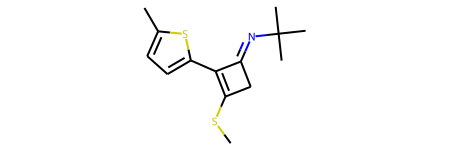

In [21]:
print(list(range(mol.GetNumAtoms())))
mol

In [35]:
atoms = mol.GetNumAtoms()
for idx in range(0, atoms):
    mol.GetAtomWithIdx(idx).SetProp('molAtomMapNumber',
                                    str(mol.GetAtomWithIdx(idx).GetIdx()))

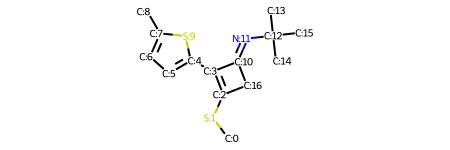

In [36]:
mol

In [39]:
# get_decision_sequence(self, mol, atom_order)

atom_order = list(range(mol.GetNumAtoms()))

decisions = []
old2new = dict()

for new_id, old_id in enumerate(atom_order):
    print('Build for new ID {}, old ID {}:'.format(new_id, old_id))
    
    atom = mol.GetAtomWithIdx(old_id)
    a_type = atom.GetSymbol()
    decisions.append((0, atom_type_to_id[a_type]))
    print('Add {}'.format((0, atom_type_to_id[a_type])))
    
    bonds = atom.GetBonds()
    print('There are {} bond(s) connected with atom {}'.format(len(bonds), old_id))
    
    for bond in bonds:
        u = bond.GetBeginAtomIdx()
        v = bond.GetEndAtomIdx()
        if v == old_id:
            u, v = v, u
        if v in old2new:
            decisions.append((1, bond_type_to_id[bond.GetBondType()]))
            decisions.append((2, old2new[v]))
            print('  start atom {}, end atom {}'.format(u, v))
            print('  {} in old2new, add {} and {}'.format(
                v, (1, bond_type_to_id[bond.GetBondType()]), (2, old2new[v])))
    
    decisions.append((1, len(bonds_type)))
    print('Add {}'.format((1, len(bonds_type))))
    old2new[old_id] = new_id
    print('Now old2new: {}'.format(old2new))

decisions.append((0, len(atoms_type)))
print('Add {}'.format((0, len(atoms_type))))

Build for new ID 0, old ID 0:
Add (0, 0)
There are 1 bond(s) connected with atom 0
Add (1, 3)
Now old2new: {0: 0}
Build for new ID 1, old ID 1:
Add (0, 3)
There are 2 bond(s) connected with atom 1
  start atom 1, end atom 0
  0 in old2new, add (1, 0) and (2, 0)
Add (1, 3)
Now old2new: {0: 0, 1: 1}
Build for new ID 2, old ID 2:
Add (0, 0)
There are 3 bond(s) connected with atom 2
  start atom 2, end atom 1
  1 in old2new, add (1, 0) and (2, 1)
Add (1, 3)
Now old2new: {0: 0, 1: 1, 2: 2}
Build for new ID 3, old ID 3:
Add (0, 0)
There are 3 bond(s) connected with atom 3
  start atom 3, end atom 2
  2 in old2new, add (1, 1) and (2, 2)
Add (1, 3)
Now old2new: {0: 0, 1: 1, 2: 2, 3: 3}
Build for new ID 4, old ID 4:
Add (0, 0)
There are 3 bond(s) connected with atom 4
  start atom 4, end atom 3
  3 in old2new, add (1, 0) and (2, 3)
Add (1, 3)
Now old2new: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
Build for new ID 5, old ID 5:
Add (0, 0)
There are 2 bond(s) connected with atom 5
  start atom 5, end atom 4


In [31]:
atom = mol.GetAtomWithIdx(0)
print(atom.GetSymbol())
print((0, atom_type_to_id['C']))

bonds = atom.GetBonds()
print(bonds)
bond = bonds[0]
print(bond)
u = bond.GetBeginAtomIdx()
v = bond.GetEndAtomIdx()
print(u, v)
print(bond.GetBondType())

C
(0, 0)
(<rdkit.Chem.rdchem.Bond object at 0x7fd2982f6c40>,)
0 1
SINGLE


In [41]:
# shuffle order

atom_order = list(range(mol.GetNumAtoms()))
random.shuffle(atom_order)

decisions = []
old2new = dict()

for new_id, old_id in enumerate(atom_order):
    print('Build for new ID {}, old ID {}:'.format(new_id, old_id))
    
    atom = mol.GetAtomWithIdx(old_id)
    a_type = atom.GetSymbol()
    decisions.append((0, atom_type_to_id[a_type]))
    print('Add {}'.format((0, atom_type_to_id[a_type])))
    
    bonds = atom.GetBonds()
    print('There are {} bond(s) connected with atom {}'.format(len(bonds), old_id))
    
    for bond in bonds:
        u = bond.GetBeginAtomIdx()
        v = bond.GetEndAtomIdx()
        if v == old_id:
            u, v = v, u
        if v in old2new:
            decisions.append((1, bond_type_to_id[bond.GetBondType()]))
            decisions.append((2, old2new[v]))
            print('  start atom {}, end atom {}'.format(u, v))
            print('  {} in old2new, add {} and {}'.format(
                v, (1, bond_type_to_id[bond.GetBondType()]), (2, old2new[v])))
    
    decisions.append((1, len(bonds_type)))
    print('Add {}'.format((1, len(bonds_type))))
    old2new[old_id] = new_id
    print('Now old2new: {}'.format(old2new))

decisions.append((0, len(atoms_type)))
print('Add {}'.format((0, len(atoms_type))))

Build for new ID 0, old ID 14:
Add (0, 0)
There are 1 bond(s) connected with atom 14
Add (1, 3)
Now old2new: {14: 0}
Build for new ID 1, old ID 4:
Add (0, 0)
There are 3 bond(s) connected with atom 4
Add (1, 3)
Now old2new: {14: 0, 4: 1}
Build for new ID 2, old ID 11:
Add (0, 1)
There are 2 bond(s) connected with atom 11
Add (1, 3)
Now old2new: {14: 0, 4: 1, 11: 2}
Build for new ID 3, old ID 10:
Add (0, 0)
There are 3 bond(s) connected with atom 10
  start atom 10, end atom 11
  11 in old2new, add (1, 1) and (2, 2)
Add (1, 3)
Now old2new: {14: 0, 4: 1, 11: 2, 10: 3}
Build for new ID 4, old ID 9:
Add (0, 3)
There are 2 bond(s) connected with atom 9
  start atom 9, end atom 4
  4 in old2new, add (1, 0) and (2, 1)
Add (1, 3)
Now old2new: {14: 0, 4: 1, 11: 2, 10: 3, 9: 4}
Build for new ID 5, old ID 0:
Add (0, 0)
There are 1 bond(s) connected with atom 0
Add (1, 3)
Now old2new: {14: 0, 4: 1, 11: 2, 10: 3, 9: 4, 0: 5}
Build for new ID 6, old ID 16:
Add (0, 0)
There are 2 bond(s) connected wi

## Minics

- `get_DGMG_smiles()`
- `eval_decisions()`

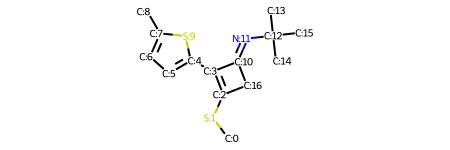

In [42]:
mol

In [49]:
canonical_decisions = env.get_decision_sequence(mol, list(range(mol.GetNumAtoms())))

In [58]:
def eval_decisions(env, decisions):
    
    env.reset(rdkit_mol=True)
    t = 0

    def whether_to_add_atom(t):
        assert decisions[t][0] == 0
        atom_type = decisions[t][1]
        t += 1
        return t, atom_type

    def whether_to_add_bond(t):
        assert decisions[t][0] == 1
        bond_type = decisions[t][1]
        t += 1
        return t, bond_type

    def decide_atom2(t):
        assert decisions[t][0] == 2
        dst = decisions[t][1]
        t += 1
        return t, dst
    
    t, atom_type = whether_to_add_atom(t)
    print(t, atom_type)
    
    while atom_type != len(env.atom_types):
        env.add_atom(atom_type)
        t, bond_type = whether_to_add_bond(t)
        while bond_type != len(env.bond_types):
            t, dst = decide_atom2(t)
            env.add_bond((env.num_atoms() - 1), dst, bond_type)
            t, bond_type = whether_to_add_bond(t)
        t, atom_type = whether_to_add_atom(t)
    
    return env.get_current_smiles()

In [59]:
eval_decisions(env, canonical_decisions)

1 0


'CSC1=C(C2=CC=C(C)S2)C(=NC(C)(C)C)C1'

In [57]:
env.add_atom()

['C', 'N', 'O', 'S', 'F', 'Cl', 'Br']